# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [103]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

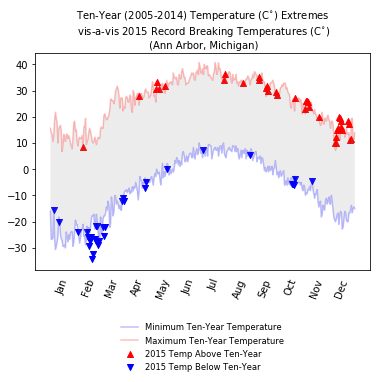

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

wtr = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')


                                                        #easier to work with intergers not have to mess with date time
                                                        #can convert to datetime later IF necessary, but based on required task
                                                        #they're mostly used for x-axis labeling
                                                        #pd.to_datetime
            
wtr['Year'], wtr['Month'], wtr['Day'] = wtr['Date'].str.split('-',3).str
wtr.Year = pd.to_numeric(wtr.Year)
wtr.Month = pd.to_numeric(wtr.Month)
wtr.Day = pd.to_numeric(wtr.Day)
wtr.Data_Value = pd.to_numeric(wtr.Data_Value)
#wtr.Data_Value = wtr.Data_Value.divide(10)

                                                        #droppping leap day, super janky that it borders on elegant
mask = (wtr.Month == 2) & (wtr.Day == 29)
wtr = wtr[~mask]

                                                        #the lines and the scatter
wtr1 = wtr[wtr.Year < 2015]
wtr2 = wtr[wtr.Year == 2015]

                                                        #creating dataframes to combine into plots
                                                        #i guess you don't have to do this as long as a "series" exist
                                                        #but it fits my visualizing if there's only one table

minSpan = wtr1.groupby(['Month','Day']).Data_Value.min().to_frame()
maxSpan = wtr1.groupby(['Month','Day']).Data_Value.max().to_frame()
min2015 = wtr2.groupby(['Month','Day']).Data_Value.min().to_frame()
max2015 = wtr2.groupby(['Month','Day']).Data_Value.max().to_frame()

wtr3 = pd.merge(minSpan,maxSpan,how='outer',left_index=True,right_index=True)
wtr4 = pd.merge(min2015,max2015,how='outer',left_index=True,right_index=True)
wtr5 = pd.merge(wtr3,wtr4,how='outer',left_index=True,right_index=True)

wtr5.columns = ['Min_Span','Max_Span','Min_2015','Max_2015']
wtr5.reset_index(inplace=True)

wtr5.Min_Span = wtr5.Min_Span.divide(10)
wtr5.Max_Span = wtr5.Max_Span.divide(10)
wtr5.Min_2015 = wtr5.Min_2015.divide(10)
wtr5.Max_2015 = wtr5.Max_2015.divide(10)

wtr5.Month = wtr5.Month.apply(str)
dic = dic = {'1':'Jan','2':'Feb','3':'Mar','4':'Apr','5':'May','6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct','11':'Nov','12':'Dec'}
wtr5.Month = wtr5.Month.map(dic)
                                                        #for the sake of pretty month labels
wtr5['LabMask'] = (wtr5.Day == 15)
wtr5.Day = wtr5.Day.apply(str)

wtr5['Label'] = wtr5.Month + '-' + wtr5.Day
wtr5['Below'] = wtr5.Min_Span > wtr5.Min_2015
wtr5['Above'] = wtr5.Max_Span < wtr5.Max_2015
wtr5['Range'] = wtr5.Max_Span - wtr5.Min_Span

wtr5.Below.replace(False,np.nan,inplace=True)
wtr5.Above.replace(False,np.nan,inplace=True)
wtr5.LabMask.replace(False,'',inplace=True)
wtr5.LabMask.replace(True,wtr5.Month,inplace=True)
                                                        #pretty time
plt.figure()

plt.scatter(wtr5.index.values, (wtr5.Max_2015.values*wtr5.Above.values), marker='^',  c='red',
            label = '2015 Temp Above Ten-Year')
plt.scatter(wtr5.index.values, (wtr5.Min_2015.values*wtr5.Below.values), marker='v',  c='blue',
            label = '2015 Temp Below Ten-Year')

plt.plot(wtr5.Min_Span.values, c='blue', alpha = .25, label = 'Minimum Ten-Year Temperature')
plt.plot(wtr5.Max_Span.values, c='red', alpha = .25, label = 'Maximum Ten-Year Temperature')

                                                        #this is a near direct copy-paste
plt.fill_between(range(len(wtr5.Min_Span.values)), 
                       wtr5.Min_Span.values, wtr5.Max_Span.values, 
                       facecolor='gray', 
                       alpha=0.15)

plt.xticks(np.arange(len(wtr5)), wtr5.LabMask.values)
plt.legend(bbox_to_anchor=(.5, -.5), loc='lower center', ncol=1, fancybox=None, edgecolor='white', fontsize='small')

#THE FOLLOWING ARE DIRECT COPY PASTE FROM THE INTERNET

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on')  # labels along the bottom edge are off

q = plt.gca().xaxis

# rotate the tick labels for the x axis
for item in q.get_ticklabels():
    item.set_rotation(70)

#below box

plt.title ('Ten-Year (2005-2014) Temperature (C$^{\circ}$) Extremes \n vis-a-vis 2015 Record Breaking Temperatures (C$^{\circ}$) \n (Ann Arbor, Michigan)',fontsize='medium')
plt.savefig('wtr.png')
plt.show()


In [82]:
?plt.xlabel
